In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

%matplotlib notebook

<IPython.core.display.Javascript object>


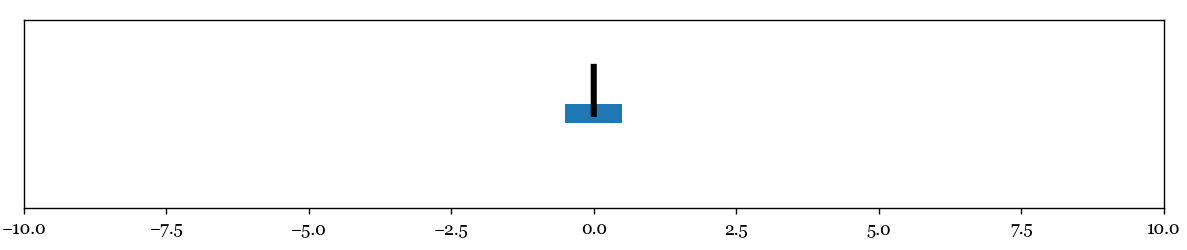

In [18]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=58 )

state = np.array( [ 1., 0, 0, 0, 0 ] )
cart_pole.set_state( state )
cart_pole._render()

In [19]:
p = np.array([-1, -1.5, 0, -1, 0]) # steady at middle

for i in range(50):

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

forces = [5, 5, -5, -5, -5, -5, 4, 4, 4, 4, -2, -2]

for i, force in enumerate(forces):
    
    state[4] = force
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    
p = np.array( [0.75971638,  1.44284499, 17.05744679,  2.66183469, 0] ) # upright at middle

for i in range(50):

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

# Task 4 - Nonlinear Control

Next, I want to design a controller that works even better - one that can keep the pole upright starting from the stable equilibrium. As a first step, I manually designed such a policy as follows.
1. Use a linear controller to bring the cartpole to the stable equilibrium, at the origin.
2. Apply a certain sequence of force inputs to swing up the pole.
3. Use a previously found linear policy to keep the pole upright.

For step 1, I used standard PD controller tuning technqiues to find a policy vector p = [ -1, -1.5, 0, -1 ]. For step 3, I used the policy vector I found in task 2.3, p = [ 0.76, 1.44, 17.06, 2.66 ]. For step two, I applied some intuition that the cart will need to swing back and forth to raise up the pole gradually over a few oscillations. I therefore started with a list of force values that alternated in sign every few time steps, then tuned the exact values until the second linear policy could "catch" the system in its resultant state and stablise it. The list of force values I found is [ 5, 5, -5, -5, -5, -5, 4, 4, 4, 4, -2, -2 ].

I like this approach because it leverages a human intuitive understanding of the system to simplify the problem, and works with the computer to solve it in small, manageable chunks. Designing this controller took about 15 minutes and gives ideal results. The drawback is that this type of controller will probably not work well at all in the presence of noise.

<IPython.core.display.Javascript object>


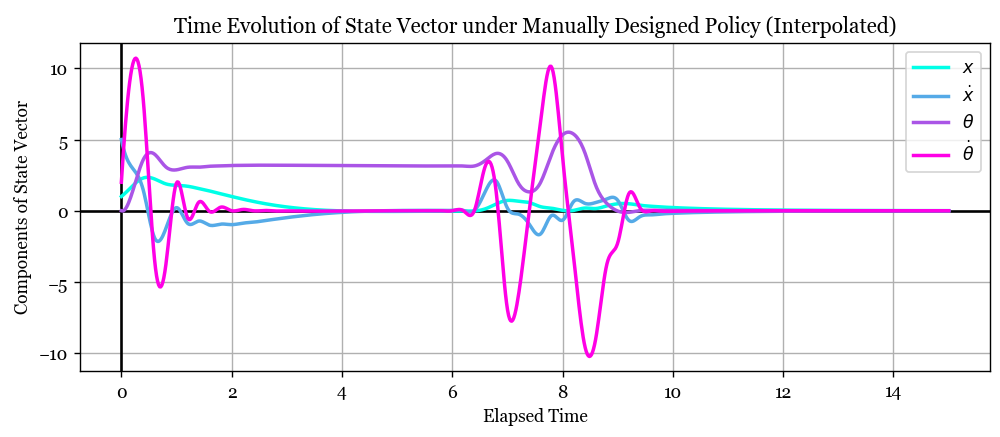

In [13]:
fig, ax = plt.subplots(1, 1, num=33, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

state = np.array( [ 1., 5, 0, 2, 0 ] ) # initial state
p = np.array([-1, -1.5, 0, -1, 0]) # steady at middle

states = []
times = []
t = 0

for i in range(32):
    
    states.append(state)
    times.append(t)

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    t += 0.2

forces = [5, 5, -5, -5, -5, -5, 4, 4, 4, 4, -2, -2]

for i, force in enumerate(forces):
    
    states.append(state)
    times.append(t)
    
    state[4] = force
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    t += 0.2
    
p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469, 0] ) # upright at middle

for i in range(32):
    
    states.append(state)
    times.append(t)

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    t += 0.2
    
states = np.array( states )
times = np.array( times )

x = times
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Manually Designed Policy (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")


Above is the time evolution of the state vector under my controller. The first set of ripples is the first linear policy bringing the cartpole from an arbitrary state to the equilibrium with the pole downwards, shown by the purple line (pole angle) being brought to rest at pi. The second set of ripples is the swing up and subsequent stabilisation in the upright configuration - after this all the states are zero as desired.

## Radial Basis Function Approach

It should also be possible to design a controller that uses radial basis functions to define the force in different regions of the state space. This force landscape would then be such that all points in the state space are guided toward the unstable equilibrium. For this problem I will use the initial condition where the cartpole is stationary at the origin, since I know a simple linear policy can bring the system to this state, or the system can be initialised in it, and it is likely that a real cartpole system would not be in an extremely erratic state to start with because of physical limitations and safety reasons.

The policy is now a sum over a few kernel functions, given by

$$
p(X) = \sum_i w_i e^{-0.5 (X-X_i)^T W (X-X_i)}
$$

I have decided to start with W as the identity matrix to reduce the number of parameters to worry about.

In [ ]:
%%time

initial_state = np.array( [ 0, 0, np.pi, 0, 0 ] )

pad0 = lambda p : np.pad( p, (0,1) )
rollout_loss_from_initial = lambda p : rollout_loss( initial_state, pad0(p) )

min_loss = 999999
best_p = None

for i in range(100):

    p0     = np.random.rand( (4) ) - 0.5
    result = scipy.optimize.minimize( rollout_loss_from_initial, p0, method="Nelder-Mead" )
    
    end_loss = rollout_loss_from_initial( result["x"] )
    
    if end_loss < min_loss:
        best_p = result["x"]
        min_loss = end_loss
        
    print(best_p, min_loss)

p = best_p